In [30]:
import pandas as pd
import scipy as sc
import numpy as np
import os


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


Project-level imports.

In [31]:
from constants import guest_types
from constants import colors
from bootstrap import bootstrap
from bootstrap import thermodynamic_bootstrap
import plotting

# Load in results

## Experimental data from Rekharsky et al.

In [32]:
from constants import experimental_deltaG

In [33]:
experimental_list = experimental_deltaG.split("\n")
experimental = pd.DataFrame([i.split("\t") for i in experimental_list],
            columns=["System", "Delta G", "SEM"])
experimental["Delta G"] = pd.to_numeric(experimental["Delta G"])
experimental["SEM"] = pd.to_numeric(experimental["SEM"])

## Load in the BGBG-TIP3P and BGBG-TIP3P data

In [34]:
from constants import systems

In [35]:
bgbg_tip3p = pd.DataFrame()

for system in systems:

    # BGBG-TIP3P (GAFF v1.7)

    prefix = os.path.join("systems", system, "bgbg-tip3p")
    bgbg_tip3p_attach = np.genfromtxt(os.path.join(prefix, "ti-a.dat"))
    bgbg_tip3p_pull = np.genfromtxt(os.path.join(prefix, "ti-u.dat"))

    if system[0] == "a":
        bgbg_tip3p_release = np.genfromtxt(
            os.path.join("systems", "a-release", "bgbg-tip3p", "ti-r.dat")
        )
    else:
        bgbg_tip3p_release = np.genfromtxt(
            os.path.join("systems", "b-release", "bgbg-tip3p", "ti-r.dat")
        )
    bgbg_tip3p_analytic = 7.14

    delta_g = -1 * (
        bgbg_tip3p_attach[-1, 1]
        + bgbg_tip3p_pull[-1, 1]
        - bgbg_tip3p_release[-1, 1]
        - bgbg_tip3p_analytic
    )
    delta_g_sem = np.sqrt(
        bgbg_tip3p_attach[-1, 2] ** 2
        + bgbg_tip3p_pull[-1, 2] ** 2
        + bgbg_tip3p_release[-1, 2] ** 2
    )

    bgbg_tip3p = bgbg_tip3p.append(
        {"System": system, "Delta G": delta_g, "SEM": delta_g_sem, "Type": guest_types[system[0:-2]]}, ignore_index=True
    )


In [36]:
bgbg_tip3p.head()

,Delta G,SEM,System,Type
0,-0.016103,0.234765,a-bam-p,aliphatic_ammoniums
1,-0.616992,0.270263,a-bam-s,aliphatic_ammoniums
2,-0.335027,0.312059,a-but-p,aliphatic_carboxylates
3,-0.846324,0.255411,a-but-s,aliphatic_carboxylates
4,-0.264900,0.265886,a-cbu-p,cyclic_alcohols


In [37]:
bg2bg2_tip3p = pd.DataFrame()

for system in systems:

    # BG2BG2-TIP3P (GAFF v2.1)

    prefix = os.path.join("systems", system, "bg2bg2-tip3p")
    bg2bg2_tip3p_attach = np.genfromtxt(os.path.join(prefix, "ti-a.dat"))
    bg2bg2_tip3p_pull = np.genfromtxt(os.path.join(prefix, "ti-u.dat"))

    if system[0] == "a":
        bg2bg2_tip3p_release = np.genfromtxt(
            os.path.join("systems", "a-release", "bg2bg2-tip3p", "ti-r.dat")
        )
    else:
        bg2bg2_tip3p_release = np.genfromtxt(
            os.path.join("systems", "b-release", "bg2bg2-tip3p", "ti-r.dat")
        )
    bg2bg2_tip3p_analytic = 7.14

    delta_g = -1 * (
        bg2bg2_tip3p_attach[-1, 1]
        + bg2bg2_tip3p_pull[-1, 1]
        - bg2bg2_tip3p_release[-1, 1]
        - bg2bg2_tip3p_analytic
    )
    delta_g_sem = np.sqrt(
        bg2bg2_tip3p_attach[-1, 2] ** 2
        + bg2bg2_tip3p_pull[-1, 2] ** 2
        + bg2bg2_tip3p_release[-1, 2] ** 2
    )

    bg2bg2_tip3p = bg2bg2_tip3p.append(
        {"System": system, "Delta G": delta_g, "SEM": delta_g_sem, "Type": guest_types[system[0:-2]]}, ignore_index=True
    )


In [38]:
bg2bg2_tip3p.head()

,Delta G,SEM,System,Type
0,0.150013,0.229452,a-bam-p,aliphatic_ammoniums
1,-2.930536,0.235066,a-bam-s,aliphatic_ammoniums
2,-1.369206,0.234800,a-but-p,aliphatic_carboxylates
3,-3.103348,0.231945,a-but-s,aliphatic_carboxylates
4,-2.064314,0.249570,a-cbu-p,cyclic_alcohols


## Load in SMIRNOFF99Frosst data

In [39]:
from paprika.restraints_json import json_numpy_obj_hook
import json

In [40]:
def load_results(filepath="results.json"):
    with open(os.path.join(filepath), "r") as f:
        json_data = f.read()
    loaded = json.loads(json_data, object_hook=json_numpy_obj_hook)
    return loaded


In [41]:
smirnoff = pd.DataFrame()

for system in systems:
    results = load_results(f"results/{system}-results.json")
    results_release = load_results(f"results/{system[0]}-release.json")
    
    smirnoff_attach = results["attach"]["ti-block"]["fe"]
    smirnoff_pull = results["pull"]["ti-block"]["fe"]
    smirnoff_release = results_release["release"]["ti-block"]["fe"]
    
    smirnoff_attach_sem = results["attach"]["ti-block"]["sem"]
    smirnoff_pull_sem = results["pull"]["ti-block"]["sem"]
    smirnoff_release_sem = results_release["release"]["ti-block"]["sem"]
        
    smirnoff_analytic = 7.14

    delta_g = (
        -1 * (smirnoff_attach
        + smirnoff_pull
        - smirnoff_release
        - smirnoff_analytic)
    )
    delta_g_sem = np.sqrt(
        smirnoff_attach_sem ** 2
        + smirnoff_pull_sem ** 2
        + smirnoff_release_sem ** 2
    )

    smirnoff = smirnoff.append(
        {"System": system, "Delta G": delta_g, "SEM": delta_g_sem, "Type": guest_types[system[0:-2]]}, ignore_index=True
    )


In [42]:
smirnoff.head()

,Delta G,SEM,System,Type
0,-3.236993,0.451365,a-bam-p,aliphatic_ammoniums
1,-0.544564,0.380773,a-bam-s,aliphatic_ammoniums
2,0.202175,0.298335,a-but-p,aliphatic_carboxylates
3,-1.440784,0.287627,a-but-s,aliphatic_carboxylates
4,-0.789488,0.289186,a-cbu-p,cyclic_alcohols


# Plot comparisons

In [44]:
def scatter(df, x, y, xerr, yerr, xlabel, ylabel, colors, name):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, typ in enumerate(df["Type"].unique()):
        tmp = df[df["Type"] == typ]        
        ax.errorbar(
            tmp[x],
            tmp[y],
            xerr=tmp[xerr],
            yerr=tmp[yerr],
            fmt="o",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",
            color=colors[typ],
        )

        type_statistics = bootstrap(
            x=tmp[x].values,
            x_sem=tmp[xerr].values,
            y=tmp[y].values,
            y_sem=tmp[yerr].values,
            cycles=1000,
        )
        type_string = f"R$^2$ = {type_statistics['mean']['R**2']:0.2f}"
        artist = ax.annotate(
            type_string,
            (0.98, 0.02 + 0.05 * index),
            xytext=(4, -4),
            xycoords="axes fraction",
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom",
            size=14,
            color=colors[typ],
            transform=ax.transAxes,
        )

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 2)
    ax.set_xlim(-8, 2)

    statistics = bootstrap(
        x=df[x], x_sem=df[xerr], y=df[y], y_sem=df[yerr], cycles=1000
    )

    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}]"
    text += "\n"
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}]"
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=14,
        backgroundcolor="white",
        transform=ax.transAxes,
    )
    fig.savefig(f"figures/{name}", bbox_inches="tight")

In [81]:
# This is not very tidy.
def scatter_large(df, x, y, xerr, yerr, xlabel, ylabel, colors, name):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    sns.reset_orig()
    sns.set(font_scale=2)
    mpl.rc("text", usetex=True)
    mpl.rcParams["text.latex.preamble"] = [
        r"\usepackage{amsmath}",
        r"\usepackage{helvet}",
        r"\usepackage[EULERGREEK]{sansmath}",
        r"\sansmath",
        r"\renewcommand{\familydefault}{\sfdefault}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage{graphicx}",
    ]

    for index, typ in enumerate(df["Type"].unique()):
        tmp = df[df["Type"] == typ]        
        ax.errorbar(
            tmp[x],
            tmp[y],
            xerr=tmp[xerr],
            yerr=tmp[yerr],
            fmt="o",
            markersize=10,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",
            color=colors[typ],
        )

        type_statistics = bootstrap(
            x=tmp[x].values,
            x_sem=tmp[xerr].values,
            y=tmp[y].values,
            y_sem=tmp[yerr].values,
            cycles=1000,
        )
        type_string = f"R$^2$ = {type_statistics['mean']['R**2']:0.2f}"
        artist = ax.annotate(
            type_string,
            (0.98, 0.02 + 0.07 * index),
            xytext=(4, -4),
            xycoords="axes fraction",
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom",
            size=20,
            color=colors[typ],
            transform=ax.transAxes,
        )

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 2)
    ax.set_xlim(-8, 2)

    statistics = bootstrap(
        x=df[x], x_sem=df[xerr], y=df[y], y_sem=df[yerr], cycles=1000
    )

    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}]"
    text += "\n"
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}]"
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=20,
        backgroundcolor="white",
        transform=ax.transAxes,
    )
    sns.set_style("whitegrid")
    fig.savefig(f"figures/{name}", bbox_inches="tight")

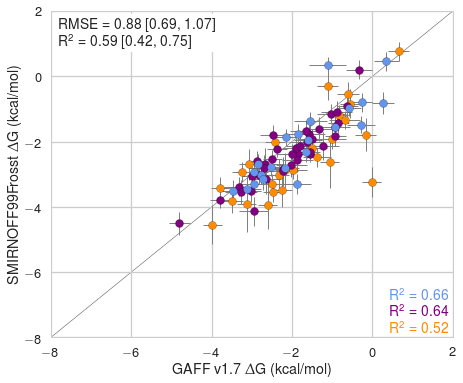

In [45]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff.merge(bgbg_tip3p, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg_tip3p"))
assert(len(df) == 86)

artist = scatter(df, 
        x="Delta G_bgbg_tip3p",
        y="Delta G_smirnoff",
        xerr="SEM_bgbg_tip3p",
        yerr="SEM_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-dG.pdf")

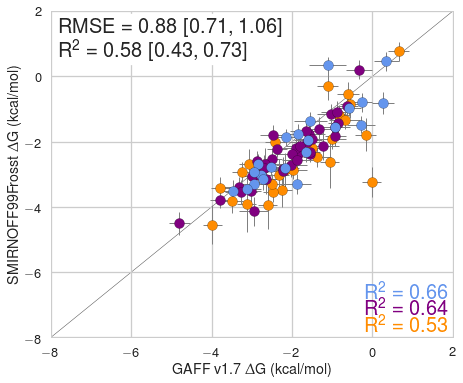

In [57]:
df = smirnoff.merge(bgbg_tip3p, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg_tip3p"))
assert(len(df) == 86)

artist = scatter_large(df, 
        x="Delta G_bgbg_tip3p",
        y="Delta G_smirnoff",
        xerr="SEM_bgbg_tip3p",
        yerr="SEM_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-dG.pdf")

In [53]:
tmp = smirnoff.merge(bgbg_tip3p, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg_tip3p"))

slope, intercept, r_value, p_value, std_err = sc.stats.linregress(tmp["Delta G_bgbg_tip3p"], tmp["Delta G_smirnoff"])
print(slope)
print(intercept)
print(r_value)
print(r_value**2)

0.8567151021742689
-0.675090899199164
0.8407448164783092
0.7068518464351459


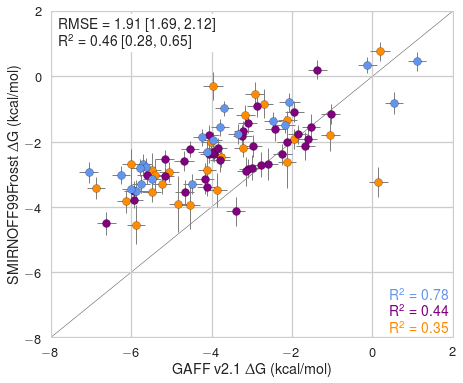

In [46]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff.merge(bg2bg2_tip3p, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="Delta G_bg2bg2_tip3p",
        y="Delta G_smirnoff",
        xerr="SEM_bg2bg2_tip3p",
        yerr="SEM_smirnoff",
        xlabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-dG.pdf")

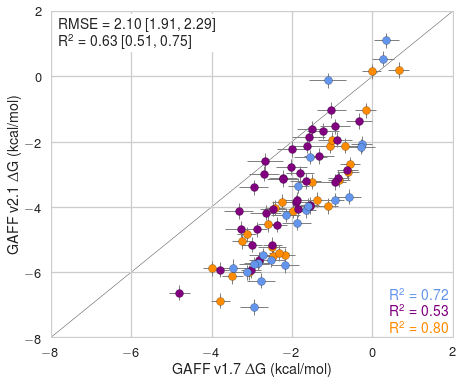

In [47]:
# GAFF v1.7 vs. GAFF v2.1

df = bgbg_tip3p.merge(bg2bg2_tip3p, on=["System", "Type"], suffixes=("_bgbg_tip3p",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="Delta G_bgbg_tip3p",
        y="Delta G_bg2bg2_tip3p",
        xerr="SEM_bgbg_tip3p",
        yerr="SEM_bg2bg2_tip3p",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-dG.pdf")

In [21]:
def combine_data(df):

    combined = pd.DataFrame()
    df["Short"] = [i[0:-2] for i in df["System"].values]

    for hg in df["Short"].unique():
        tmp = df[df["Short"] == hg]
        for _, row in tmp.iterrows():
            for p in row["System"].split("-")[2]:
                primary_fe = row["Delta G"]
                primary_sem = row["SEM"]
            else:
                secondary_fe = row["Delta G"]
                secondary_sem = row["SEM"]
        results = thermodynamic_bootstrap(
            primary_fe, primary_sem, secondary_fe, secondary_sem
        )

        print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
        combined = combined.append(
            {
                "System": hg,
                "Delta G": results["mean"],
                "SEM": results["sem"],
                "Type": guest_types[hg],
            },
            ignore_index=True,
        )
    return combined


In [22]:
smirnoff_combined = combine_data(smirnoff)

a-bam P: -0.5446 ± +0.38 S: -0.54 ± +0.38 → Boot: -1.03 ± +0.28
a-but P: -1.4408 ± +0.29 S: -1.44 ± +0.29 → Boot: -1.88 ± +0.20
a-cbu P: -0.9796 ± +0.24 S: -0.98 ± +0.24 → Boot: -1.41 ± +0.17
a-chp P: -2.3202 ± +0.31 S: -2.32 ± +0.31 → Boot: -2.77 ± +0.23
a-cpe P: -1.5650 ± +0.26 S: -1.56 ± +0.26 → Boot: -2.01 ± +0.19
a-coc P: -1.7633 ± +0.30 S: -1.76 ± +0.30 → Boot: -2.20 ± +0.22
a-hep P: -3.7776 ± +0.25 S: -3.78 ± +0.25 → Boot: -4.21 ± +0.18
a-ham P: -3.4800 ± +0.53 S: -3.48 ± +0.53 → Boot: -3.98 ± +0.39
a-hp6 P: -3.0652 ± +0.30 S: -3.07 ± +0.30 → Boot: -3.52 ± +0.21
a-hex P: -2.5262 ± +0.26 S: -2.53 ± +0.26 → Boot: -2.97 ± +0.19
a-hx2 P: -2.2245 ± +0.24 S: -2.22 ± +0.24 → Boot: -2.66 ± +0.17
a-hpa P: -3.9136 ± +0.85 S: -3.91 ± +0.85 → Boot: -4.57 ± +0.66
a-mba P: -1.1912 ± +0.32 S: -1.19 ± +0.32 → Boot: -1.65 ± +0.23
a-hx3 P: -0.9247 ± +0.31 S: -0.92 ± +0.31 → Boot: -1.37 ± +0.23
a-mhp P: -3.8299 ± +0.35 S: -3.83 ± +0.35 → Boot: -4.30 ± +0.26
a-mha P: -3.5475 ± +0.31 S: -3.55 ± +0.3

In [23]:
bgbg_combined = combine_data(bgbg_tip3p)

a-bam P: -0.6170 ± +0.27 S: -0.62 ± +0.27 → Boot: -1.06 ± +0.20
a-but P: -0.8463 ± +0.26 S: -0.85 ± +0.26 → Boot: -1.30 ± +0.18
a-cbu P: -0.5799 ± +0.30 S: -0.58 ± +0.30 → Boot: -1.03 ± +0.22
a-chp P: -1.6652 ± +0.25 S: -1.67 ± +0.25 → Boot: -2.11 ± +0.18
a-cpe P: -0.9364 ± +0.24 S: -0.94 ± +0.24 → Boot: -1.37 ± +0.17
a-coc P: -1.8421 ± +0.25 S: -1.84 ± +0.25 → Boot: -2.29 ± +0.19
a-hep P: -3.8065 ± +0.24 S: -3.81 ± +0.24 → Boot: -4.23 ± +0.17
a-ham P: -2.2582 ± +0.24 S: -2.26 ± +0.24 → Boot: -2.69 ± +0.17
a-hp6 P: -2.9889 ± +0.25 S: -2.99 ± +0.25 → Boot: -3.43 ± +0.18
a-hex P: -2.4880 ± +0.24 S: -2.49 ± +0.24 → Boot: -2.92 ± +0.17
a-hx2 P: -2.3726 ± +0.24 S: -2.37 ± +0.24 → Boot: -2.81 ± +0.17
a-hpa P: -3.1280 ± +0.24 S: -3.13 ± +0.24 → Boot: -3.56 ± +0.18
a-mba P: -0.8369 ± +0.27 S: -0.84 ± +0.27 → Boot: -1.28 ± +0.19
a-hx3 P: -0.6223 ± +0.27 S: -0.62 ± +0.27 → Boot: -1.06 ± +0.18
a-mhp P: -3.4885 ± +0.26 S: -3.49 ± +0.26 → Boot: -3.93 ± +0.19
a-mha P: -2.4821 ± +0.24 S: -2.48 ± +0.2

In [24]:
bg2bg2_combined = combine_data(bg2bg2_tip3p)

a-bam P: -2.9305 ± +0.24 S: -2.93 ± +0.24 → Boot: -3.37 ± +0.17
a-but P: -3.1033 ± +0.23 S: -3.10 ± +0.23 → Boot: -3.54 ± +0.17
a-cbu P: -3.6854 ± +0.22 S: -3.69 ± +0.22 → Boot: -4.12 ± +0.16
a-chp P: -4.1086 ± +0.23 S: -4.11 ± +0.23 → Boot: -4.55 ± +0.15
a-cpe P: -3.7901 ± +0.23 S: -3.79 ± +0.23 → Boot: -4.22 ± +0.16
a-coc P: -3.3514 ± +0.24 S: -3.35 ± +0.24 → Boot: -3.78 ± +0.17
a-hep P: -5.9339 ± +0.23 S: -5.93 ± +0.23 → Boot: -6.37 ± +0.17
a-ham P: -3.8568 ± +0.23 S: -3.86 ± +0.23 → Boot: -4.29 ± +0.17
a-hp6 P: -5.1644 ± +0.23 S: -5.16 ± +0.23 → Boot: -5.60 ± +0.16
a-hex P: -5.1705 ± +0.23 S: -5.17 ± +0.23 → Boot: -5.60 ± +0.17
a-hx2 P: -4.5445 ± +0.23 S: -4.54 ± +0.23 → Boot: -4.98 ± +0.17
a-hpa P: -4.8344 ± +0.23 S: -4.83 ± +0.23 → Boot: -5.27 ± +0.16
a-mba P: -3.1663 ± +0.23 S: -3.17 ± +0.23 → Boot: -3.60 ± +0.16
a-hx3 P: -2.8803 ± +0.24 S: -2.88 ± +0.24 → Boot: -3.32 ± +0.18
a-mhp P: -6.1231 ± +0.24 S: -6.12 ± +0.24 → Boot: -6.55 ± +0.17
a-mha P: -5.4952 ± +0.24 S: -5.50 ± +0.2

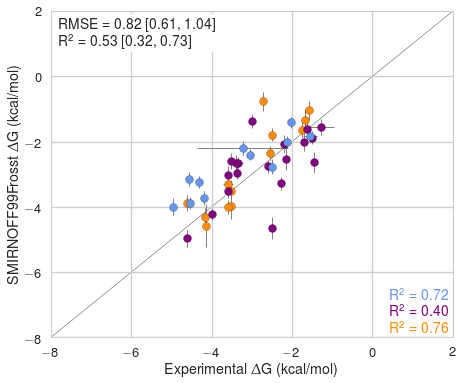

In [48]:
# SMIRNOFF99Frosst vs. Experiment

df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="SEM_experiment",
        yerr="SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experiment-dG.pdf")

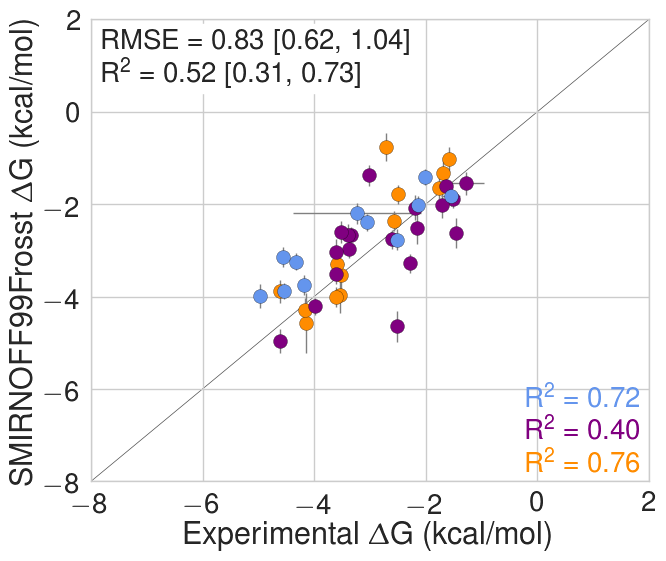

In [82]:
# SMIRNOFF99Frosst vs. Experiment

df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
assert(len(df) == 43)

scatter_large(df, 
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="SEM_experiment",
        yerr="SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experiment-dG.pdf")

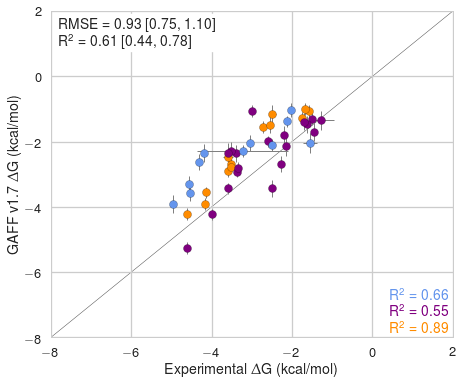

In [49]:
# GAFF v1.7 vs. Experiment

df = bgbg_combined.merge(experimental, on=["System"], suffixes=("_bgbg",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_experiment",
        y="Delta G_bgbg",
        xerr="SEM_experiment",
        yerr="SEM_bgbg",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v1.7-vs-Experiment-dG.pdf")

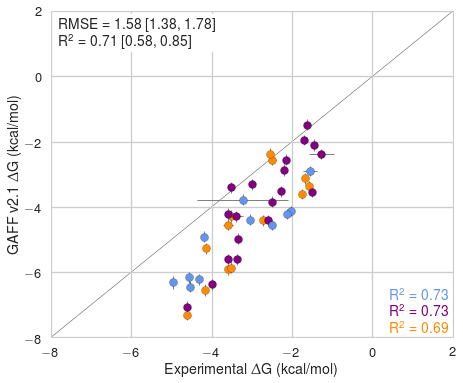

In [50]:
# GAFF v2.1 vs. Experiment

df = bg2bg2_combined.merge(experimental, on=["System"], suffixes=("_bg2bg2",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_experiment",
        y="Delta G_bg2bg2",
        xerr="SEM_experiment",
        yerr="SEM_bg2bg2",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-Experiment-dG.pdf")

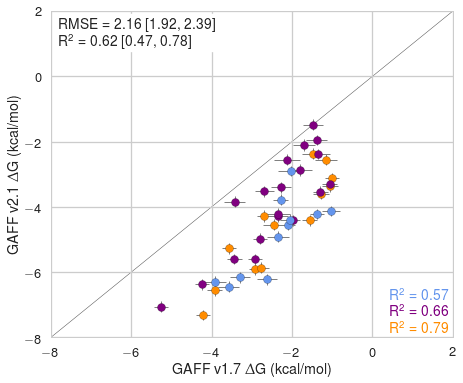

In [51]:
# GAFF v1.7 vs. GAFF v2.1

df = bg2bg2_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_bg2bg2",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_bgbg",
        y="Delta G_bg2bg2",
        xerr="SEM_bgbg",
        yerr="SEM_bg2bg2",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-combined-dG.pdf")

In [29]:
df[abs(df["Delta G_bg2bg2"] - df["Delta G_bgbg"]) < 0.05]

,Delta G_bg2bg2,SEM_bg2bg2,System,Type,Delta G_bgbg,SEM_bgbg
22,-1.477105,0.166116,b-ben,aliphatic_carboxylates,-1.473535,0.254618
